In [82]:
# Packages
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
colors1 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
colors2 = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colors2)
%matplotlib inline

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# New in this tutorial
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

# Other functions
from statlearning import plot_feature_importance, plot_feature_importance_boost

In [5]:
# Auxiliary functions
def log_transform(x, train, test):
    train[x] = np.log(train[x])
    test[x] = np.log(test[x])
    return train, test

from scipy.stats import boxcox

def box_cox_transform(x, train, test, shift=0.0):
    y, param  = boxcox(train[x]+shift)
    train[x] = y
    test[x] = boxcox(test[x]+shift, param)
    return train, test

In [6]:
data = pd.read_csv('LoanStats-clean.csv')
data.head()

,funded_amnt,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_acc,months_since_earliest_cr_line,emp_length,...,term_60,home_ownership_own,home_ownership_rent,verification_status_source verified,verification_status_verified,months_to_last_pymnt,total_pymnt,total_rec_prncp,total_rec_int,fully_paid
0,5000.0,10.65,162.87,24000.0,27.65,13648.0,83.7,9.0,323,10,...,0,0,1,0,1,37,5863.155187,5000.00,863.16,1
1,2500.0,15.27,59.83,30000.0,1.00,1687.0,9.4,4.0,152,0,...,1,0,1,1,0,16,1014.530000,456.46,435.17,0
2,2400.0,15.96,84.33,12252.0,8.72,2956.0,98.5,10.0,121,10,...,0,0,1,0,0,30,3005.666844,2400.00,605.67,1
3,10000.0,13.49,339.31,49200.0,20.00,5598.0,21.0,37.0,190,10,...,0,0,1,1,0,37,12231.890000,10000.00,2214.92,1
4,3000.0,12.69,67.79,80000.0,17.94,27783.0,53.9,38.0,191,1,...,1,0,1,1,0,61,4066.908161,3000.00,1066.91,1


In [7]:
variables = pd.read_csv('LoanStats-clean-variables.csv')
variables.head()

,name,type
0,funded_amnt,continuous
1,int_rate,continuous
2,installment,continuous
3,annual_inc,continuous
4,dti,continuous


In [8]:
variables['type'].value_counts()

continuous     9
discrete       6
outcome        5
dummy          5
response       1
categorical    1
Name: type, dtype: int64

In [9]:
response = variables.loc[variables['type'] == 'response', 'name'].values[0]
outcomes = list(variables.loc[variables['type'] == 'outcome', 'name'])
continuous =  list(variables.loc[variables['type'] == 'continuous', 'name'])
discrete = list(variables.loc[variables['type'] == 'discrete', 'name'])
dummies = list(variables.loc[variables['type'] == 'dummy', 'name'])
categorical = list(variables.loc[variables['type'] == 'dummy', 'name'])

In [10]:
outcomes

['months_to_last_pymnt',
 'total_pymnt',
 'total_rec_prncp',
 'total_rec_int',
 'last_pymnt_amnt']

In [11]:
response

'fully_paid'

In [12]:
continuous


['funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'revol_util',
 'total_acc',
 'months_since_earliest_cr_line']

# Business Problem

#### So our business problem invovles deciding for each investor if he/she should invest in a particular investment option. This entails that the gain from lending should be greater than the opportunity cost. Hence we will construct a classification matrix that will help us decide what to do. 




#### True positive : return from interest payment

#### False positive: bad debts-loss from default

#### True negative : returns from alternative source
    


#### False negative : returns from alternative source

In [13]:

returns = np.array(data['int_rate'].copy())

for i in range(len(data)):
    
    if data['fully_paid'].iloc[i]==0: # if default for observation i
        
        # number of payments
        periods = data['months_to_last_pymnt'].iloc[i]   
       
        # we assume equal payments until default 
        cash_flow = data['total_pymnt'].iloc[i]/periods
        
        # rate formula from cash flows and present value
        ret =  np.rate(periods, -cash_flow, data['funded_amnt'].iloc[i], fv=0)
        returns[i] = 100*((1+ret)**12-1)

data['return'] = returns

In [14]:
data['return'].head(5)

0    10.650000
1   -68.027757
2    15.960000
3    13.490000
4    12.690000
Name: return, dtype: float64

##### Lets split our dataset into train and test 

In [15]:
# We use a small training sample to ease the computatioinal burden
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.5, random_state=10)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()


In [16]:
train.head()

,funded_amnt,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_acc,months_since_earliest_cr_line,emp_length,...,home_ownership_own,home_ownership_rent,verification_status_source verified,verification_status_verified,months_to_last_pymnt,total_pymnt,total_rec_prncp,total_rec_int,fully_paid,return
14923,3600.0,20.25,95.88,55000.0,16.12,10430.0,98.4,20.0,188,10,...,0,0,0,0,10,3862.760116,3600.0,262.76,1,20.25
33559,12000.0,8.94,381.26,56000.0,10.26,4553.0,15.2,19.0,126,4,...,0,1,0,0,36,13725.249700,12000.0,1725.25,1,8.94
8283,25000.0,11.99,555.99,52000.0,24.74,17357.0,29.4,43.0,235,10,...,0,1,0,1,32,31312.607230,25000.0,6312.61,1,11.99
14407,14000.0,7.49,435.43,70000.0,3.17,7014.0,11.4,46.0,108,5,...,0,0,0,1,34,15659.055350,14000.0,1659.06,1,7.49
26880,6000.0,7.51,186.67,39000.0,21.38,4577.0,19.4,25.0,138,6,...,0,0,0,1,36,6720.075628,6000.0,720.08,1,7.51


In [17]:
y_train = train[response]
y_test = test[response]

In [18]:
train['return'].describe() #Average return is 3.3%

count    19479.000000
mean         3.317446
std         25.830823
min       -100.000000
25%          7.490000
50%         10.990000
75%         13.720000
max        154.826194
Name: return, dtype: float64

###### Lets see how what percentrage of people have fully paid 

In [19]:
train['fully_paid'].mean() # Around 86% 

0.8596437188767391

In [20]:
train.groupby(by='fully_paid').mean()['return']

fully_paid
0   -48.115462
1    11.715031
Name: return, dtype: float64

#### So investors loose -48% if borrowers default on their payments and get an average of 11.7% return if they repay. Hence our False positive is -48%. Our true negative and false negative is 3.3%, classifying every thing as positive and get their average

In [21]:
loss_fn = -3.3
loss_tn = -3.3
loss_fp= -48
loss_tp = -test['int_rate']


In [22]:
tau = (loss_fp - loss_tn) / (loss_fp + loss_fn - loss_tp - loss_tn)

In [23]:
tau.describe().round(2)

count    19480.00
mean         1.26
std          0.14
min          1.05
25%          1.16
50%          1.24
75%          1.34
max          1.89
Name: int_rate, dtype: float64

# Lets do some Exploratory data analysis 

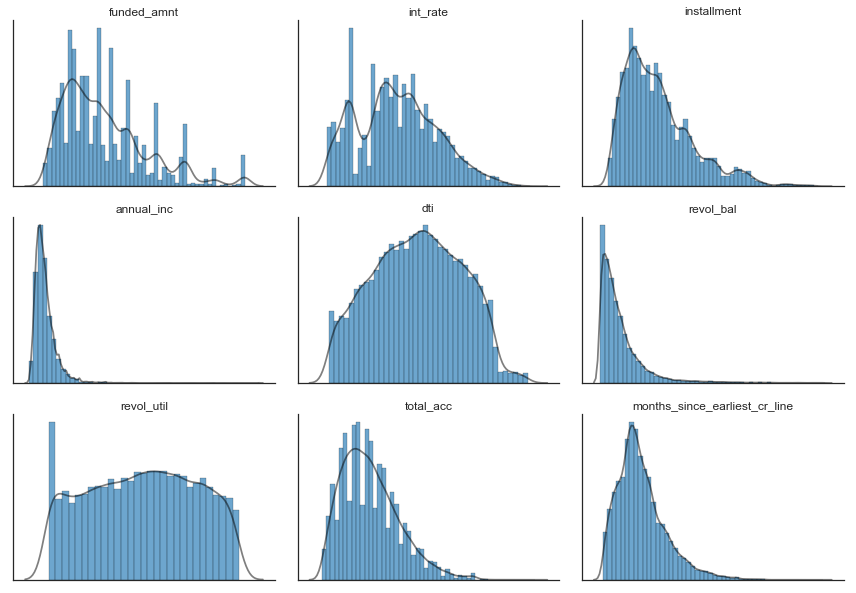

In [24]:
#define a function
fig, axes = plt.subplots(4,3, figsize=(12,11))

for i, ax in enumerate(fig.axes):
    if i < len(continuous):
        sns.distplot(train[continuous[i]], ax=ax, hist_kws={'alpha': 0.65, 'edgecolor':'black', 'color' : colors1[0]},  
                     kde_kws={'color': 'black', 'alpha': 0.5})
        ax.set_xlabel('')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(continuous[i])
    else:
        fig.delaxes(ax)

sns.despine()
plt.tight_layout()
plt.show()

### lets find out the kurtosis and skewness of the continuous variables

In [27]:
table = pd.DataFrame(train[continuous].skew().round(2),columns=['Skewness'])
table['Kurtosis'] = train[continuous].kurt().round(2)

In [28]:
table

,Skewness,Kurtosis
funded_amnt,1.09,0.95
int_rate,0.28,-0.49
installment,1.14,1.28
annual_inc,4.93,52.37
dti,-0.02,-0.83
revol_bal,3.25,15.23
revol_util,-0.05,-1.11
total_acc,0.83,0.68
months_since_earliest_cr_line,1.18,2.12


###### Most of our variables are positively skewed. We can apply log transformation on it. Highest skewness is in annual income and revolving balance

In [29]:
train,test = log_transform('annual_inc',train,test)
train,test = log_transform('months_since_earliest_cr_line',train,test)
train,test = box_cox_transform('revol_bal',train,test, shift=1.0)

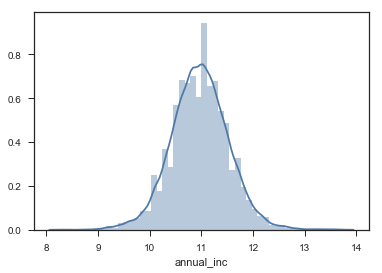

In [33]:
sns.distplot(train['annual_inc'])

In [36]:
from statlearning import plot_logistic_regressions

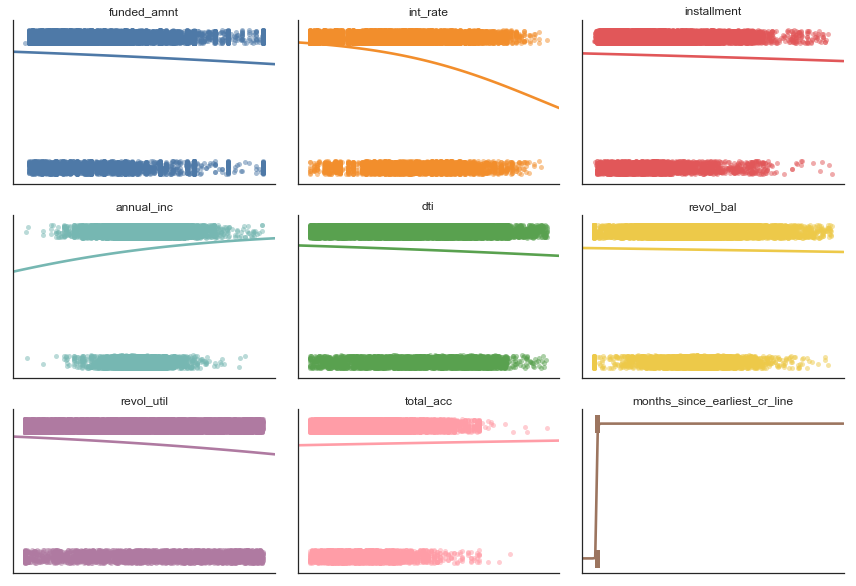

In [37]:
plot_logistic_regressions(train[continuous],y_train)
plt.show()

#### Now lets observe the KDE plots for our continuous variables

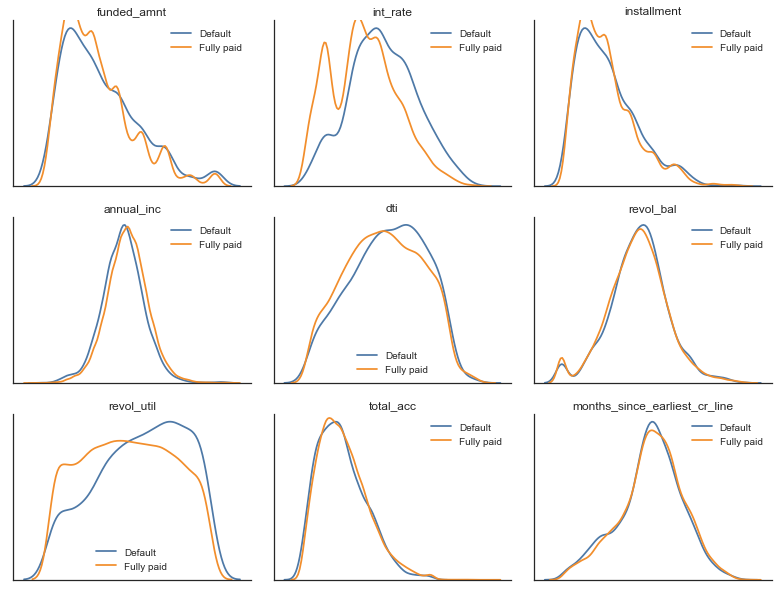

In [41]:
fig, axes = plt.subplots(4,3, figsize=(11,11))

for i, ax in enumerate(fig.axes):

    if i<len(continuous):
        sns.kdeplot(test.loc[y_test==0, continuous[i]], ax=ax, label='Default')
        sns.kdeplot(test.loc[y_test==1, continuous[i]], ax=ax, label='Fully paid')
        ax.set_xlabel('')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(continuous[i])
    else:
        fig.delaxes(ax)

sns.despine()
plt.tight_layout()
plt.show()

#### Now lets look the purpose of taking the loan

In [42]:
train['purpose'].value_counts()

debt_consolidation    9183
credit_card           2460
other                 1953
home_improvement      1508
major_purchase        1051
small_business         899
car                    753
wedding                461
medical                353
moving                 264
vacation               201
house                  187
educational            152
renewable_energy        54
Name: purpose, dtype: int64

In [46]:
train.groupby(by='purpose').mean()['fully_paid'].sort_values(ascending=False)

purpose
major_purchase        0.895338
wedding               0.893709
credit_card           0.891057
car                   0.887118
home_improvement      0.878647
house                 0.866310
vacation              0.860697
debt_consolidation    0.854187
other                 0.852535
medical               0.841360
moving                0.840909
educational           0.835526
renewable_energy      0.814815
small_business        0.748610
Name: fully_paid, dtype: float64

#### For above variables we will use dummy variables to allow us to run our model on it 

In [55]:
dummies_purpose = pd.get_dummies(data['purpose'],drop_first=True)

In [56]:
dummies_purpose.columns

Index(['credit_card', 'debt_consolidation', 'educational', 'home_improvement',
       'house', 'major_purchase', 'medical', 'moving', 'other',
       'renewable_energy', 'small_business', 'vacation', 'wedding'],
      dtype='object')

In [61]:
train= train.join(dummies_purpose.loc[index_train,:])
test = test.join(dummies_purpose.loc[index_test,:])
dummies+= list(dummies_purpose.columns)

In [62]:
#train_a #has 40 columns

In [59]:
#train_b= pd.get_dummies(train,drop_first=True) #has 39 columns

In [64]:
test_b = pd.get_dummies(test,drop_first=True) # has 52 columns compared to 40 of normal test

In [67]:
dummies

['term_60',
 'home_ownership_own',
 'home_ownership_rent',
 'verification_status_source verified',
 'verification_status_verified',
 'credit_card',
 'debt_consolidation',
 'educational',
 'home_improvement',
 'house',
 'major_purchase',
 'medical',
 'moving',
 'other',
 'renewable_energy',
 'small_business',
 'vacation',
 'wedding']

In [71]:
predictors = continuous+discrete+dummies

In [76]:
X_train = train[predictors]
X_test = test[predictors]

In [78]:
#Lets normalize our values

mean = X_train.mean()
std = X_train.std()

X_train = X_train-mean/std
X_test = X_test-mean/std


In [79]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb


In [83]:
%%time

boost = xgb.XGBClassifier()

tuning_parameters = {'learning_rate':[0.001,0.01,0.05,0.1],
                     'n_estimators':[100,200,400,500,800],
                     'max_depth':[2,3,5,6,7]}

model_boost = GridSearchCV(boost,param_grid=tuning_parameters,cv=5)

model_boost.fit(X_train,y_train)

Wall time: 1h 12min 51s


In [84]:
model_boost.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 800}

In [85]:
bst = xgb.XGBClassifier(learning_rate=0.01,max_depth=2,n_estimators = 800)
bst.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

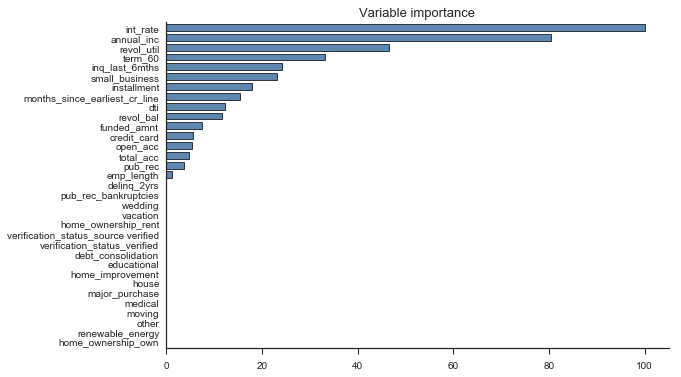

In [86]:
plot_feature_importance(bst, labels=list(X_train.columns))
plt.show()

#### As expected interest rates and annual income play a very important role in determining if the loan was repaid or not

In [87]:
%%time

rfc = RandomForestClassifier()

tuning_parameters = {'n_estimators':[100,300,500,800],
                     'criterion':['entropy','gini'],
                    'max_depth':[2,4,6,8],
                     'min_samples_leaf':[1,2,3,4,5]}
tune_rfc = GridSearchCV(estimator = rfc, param_grid=tuning_parameters,cv=5,n_jobs=2)

tune_rfc.fit(X_train,y_train)

Wall time: 32min 28s


In [88]:
tune_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [89]:
rfc_tuned = RandomForestClassifier(n_estimators=100, criterion='gini',max_depth=8,min_samples_leaf=1)
rfc_tuned.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(<matplotlib.figure.Figure at 0x2086f681ba8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x20875098358>)

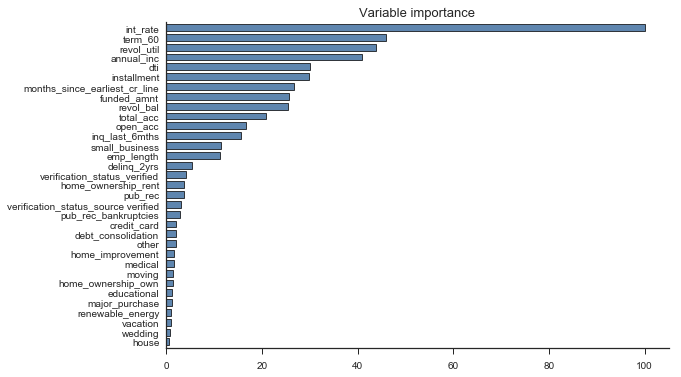

In [91]:
plot_feature_importance(rfc_tuned,labels=list(X_train.columns))

## Model stacking

In [93]:
%%time

from statlearning import stack_design_matrix, linear_probability_stack

X_train_stack= stack_design_matrix([tune_rfc, bst], [X_train, X_train],
                                   y_train, cv=5, prob=True)

KeyboardInterrupt: 